## CycleGAN - Tensorflow

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os, time, warnings
import matplotlib.pyplot as plt
from IPython.display import clear_output
warnings.filterwarnings('ignore')

AUTOTUNE = tf.data.experimental.AUTOTUNE

2024-02-07 10:22:14.399119: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-07 10:22:14.432400: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 10:22:14.432434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 10:22:14.433314: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 10:22:14.438758: I tensorflow/core/platform/cpu_feature_guar

* Input data
    - Prevent for model's Over-fitting
        1. Random jittering 
        2. Resize (convert 286x286 to 256x256)
        3. Random mirroring

In [2]:
def random_crop(image):
    """
        Cropped Images Randomly
    """
    cropped_image = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])    # H, W, C
    
    return cropped_image

def normalize(image):
    """
        Normalize Images (-1.0 ~ 1.0 range)
    """
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1

    return image

def random_jitter(image):
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = random_crop(image)
    image = tf.image.random_flip_left_right(image)

    return image

In [3]:
# Integration Preprocessing method 
def preprocess_image_train(image, label):
    image = random_jitter(image)
    image = normalize(image)

    return image

def preprocess_image_test(image, label):
    image = normalize(image)

    return image

* Import Image Dataset

In [4]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)
train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

2024-02-07 10:22:17.339411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8099 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-02-07 10:22:17.339843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1434 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1 
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
# Preprocessing Data
train_horses = train_horses.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)
train_zebras = train_zebras.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

test_horses = test_horses.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)
test_zebras = test_zebras.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1)

In [7]:
# Check Sample
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

2024-02-07 10:22:18.502362: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-02-07 10:22:18.504594: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-02-07 10:22:18.948592: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. I

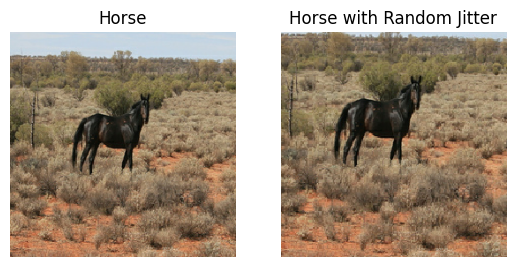

In [8]:
plt.subplot(121)
plt.title("Horse")
plt.imshow(sample_horse[0] * 0.5 + 0.5)
plt.axis('off')

plt.subplot(122)
plt.title("Horse with Random Jitter")
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)
plt.axis('off')
plt.show()

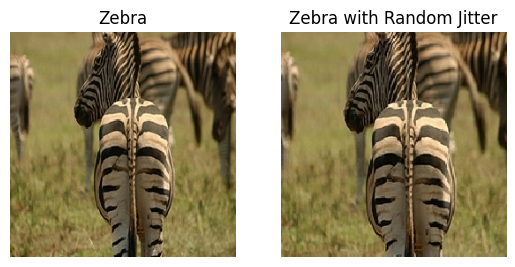

In [9]:
plt.subplot(121)
plt.title("Zebra")
plt.imshow(sample_zebra[0] * 0.5 + 0.5)
plt.axis('off')

plt.subplot(122)
plt.title("Zebra with Random Jitter")
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)
plt.axis('off')
plt.show()

# Pix2Pix 모델 로드 및 활용

* Pix2Pix의 Generator 와 Discriminator 로드
* Pix2Pix와의 차이점
    - cycleGAN 은 Batch Normalization 대신 Instance Normalization 사용
    - 논문은 ResNet 기반 Generator를 활용했지만, UNET 기반 Generator를 활용

* 2개의 Generator (G/F) 와 2개의 Discriminator (X/Y) 학습
    - Generator G : 이미지 X를 이미지 Y로 변환하는 방법 학습 (G: X->Y)
    - Generator F : 이미지 Y를 이미지 X로 변환하는 방법 학습 (G: Y->X)
    - Discriminator D_X : 이미지 X와 생성된 이미지 Y(F(Y))를 구별하는 D_X 학습
    - Discriminator D_Y : 이미지 Y와 생성된 이미지 X(F(X))를 구별하는 D_Y 학습 

<img src = "/home/hjkim/projects/local_dev/dental_cycleGAN/notebook/cyclygan.png" width = "30%" height = "30%">  

In [10]:
OUTPUT_CHANNELS = 3
# Generator
generator_g = pix2pix.unet_generator(output_channels=OUTPUT_CHANNELS, norm_type="instancenorm")
generator_f = pix2pix.unet_generator(output_channels=OUTPUT_CHANNELS, norm_type="instancenorm")

# Discriminator
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

2024-02-07 10:22:20.991394: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-02-07 10:22:21.107764: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-07 10:22:22.286075: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


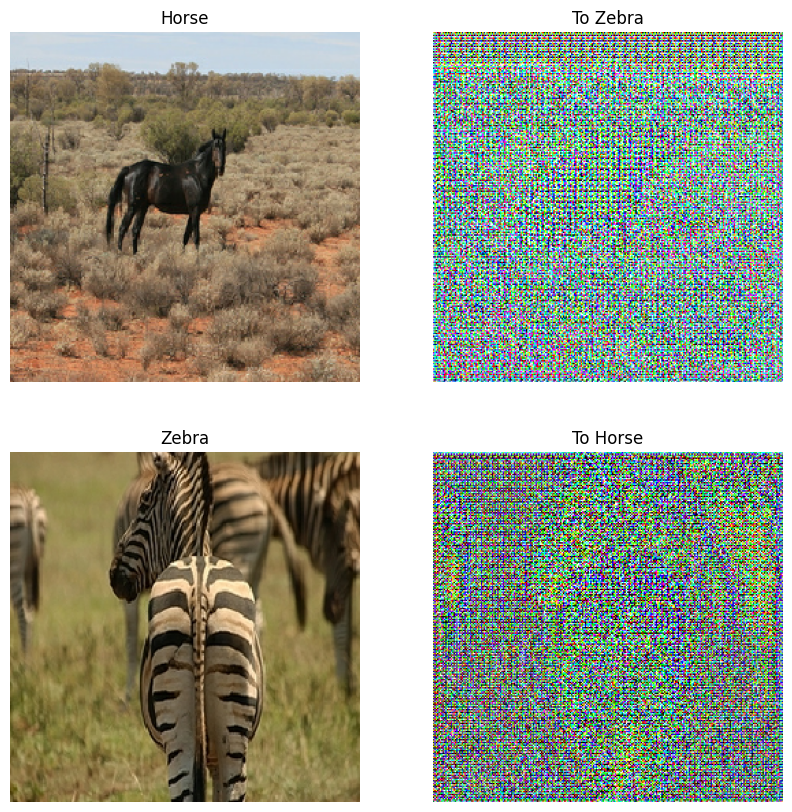

In [11]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)

plt.figure(figsize=(10, 10))
contrast = 12

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    
    if i % 2 == 0:
        plt.imshow(imgs[i][0]*0.5 + 0.5)
        plt.axis('off')
    else:
        plt.imshow(imgs[i][0]*0.5*contrast + 0.5)
        plt.axis('off')
plt.show()


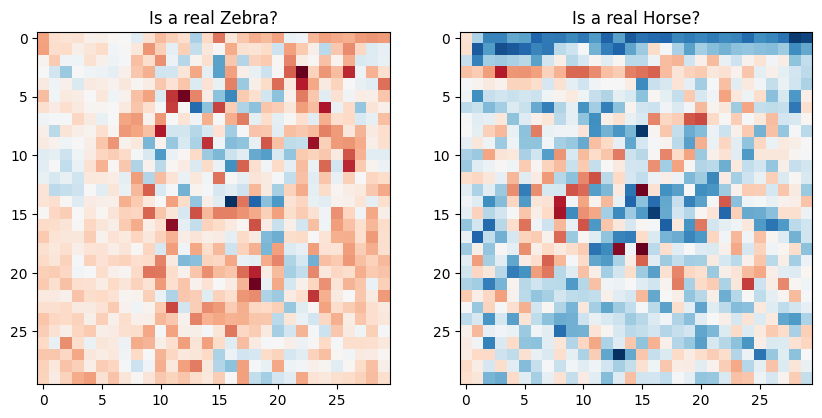

In [12]:
plt.figure(figsize=(10,10))

plt.subplot(121)
plt.title('Is a real Zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real Horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()


# Loss Function

* cycleGAN 에서는 학습할 paired한 데이터가 없으므로, 입력 X와 대상 Y 쌍이 학습중에 의미있다는 보장이 없음.
* Network가 올바른 매핑을 학습하도록 하기 위해, 논문 저자는 Cycle Consistency Loss를 제안함.
    - Cycle Consistency는 결과가 원래 입력에 가까워야 함을 의미
    - 한 문장을 영어에서 프랑스어로 번역한 후 다시 프랑스어를 영어로 번역하는 경우, 결과 문장은 원래 문장과 동일해야 좋은 모델임
    - Cycle Consistency Loss 
        - X 이미지는 생성된 Y_hat 이미지를 생성하는 Generator G를 통해 전달
        - Generated 된 이미지 Y_hat은 cycle 이미지 X_hat을 생성하는 Generator F를 통해 전달
        - 평균절대오차(Mean Absolute Error)는 X와 X_hat 사이에서 계산됨.
* Discriminator Loss 와 Generator Loss는 pix2pix에서 사용되는 것과 유사함.



<img src = "/home/hjkim/projects/local_dev/dental_cycleGAN/notebook/cyclygan2.png" width = "50%" height = "50%">  

In [21]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

* Generator G는 X 이미지를 Y 이미지로 변환
* Identity(ID) Loss 는 Y 이미지를 Generator G에 공급하면 실제 이미지 Y 또는 Y에 가까운 이미지를 생성해야 함.
* 말에서 zebra-to-horse 모델을 실행하거나, 얼룩말에서 horse-to-zebra 모델을 실행하는 경우, 이미지에 이미 대상 클래스가 포함되어잇으므로 이미지를 많이 수정하면 안됨.

- ID Loss = | G(Y) - Y | + | F(X) - X |

In [22]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [24]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Optimizer

In [26]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoint

In [28]:
checkpoint_path = './checkpoint/train'

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           # Optimizer
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer
                           )
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest Checkpoint restored.")


# Training

In [29]:
EPOCHS = 200

def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12,12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1,2,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5 + 0.5)
        plt.axis('off')
    plt.show()


In [34]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        # Loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)   
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x) 

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y) 

    # Gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y .trainable_variables)
    # Optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

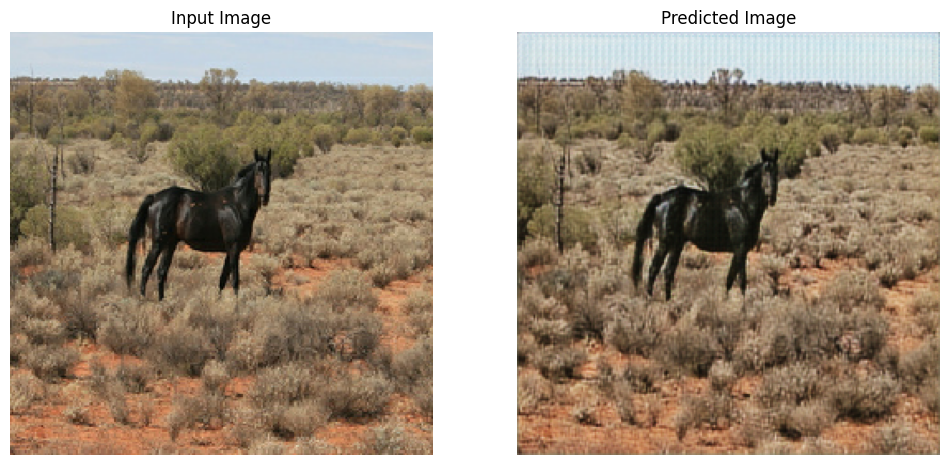

Time Taken for epoch 2 is 77.0342047214508 sec

..................

In [35]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    clear_output(wait=True)
    generate_images(generator_g, sample_horse)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f"Saving checkpoint for poech { epoch+1 } at { ckpt_save_path }")

    print(f"Time Taken for epoch { epoch + 1 } is { time.time() - start } sec\n")